# Adversarial Training on CIFAR-10 with FGSM (targeted and non-targeted) and PGD attacks 
Sharif University of Technology

#### Build ResnNet18 over cifar10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

import pickle


## Question 1

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

In [ ]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


###Training

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)


def test(epoch):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)


In [ ]:
train_losses=[]
test_losses=[]
epochs=40

for epoch in range(0,epochs):
    train_losses.append(train(epoch))
    test_losses.append(test(epoch))
    scheduler.step()

print('Accuracy of the network on the test images: %d %%' % (acc))

####Training and Test loss of Resnet18 model on Cifar-10

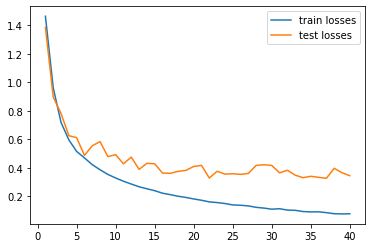

In [ ]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel='epochs'
plt.ylabel='losses'
plt.legend()
plt.show()

### Evaluating

In [ ]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = dataiter.next()

In [ ]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)
outputs= net(org_images)
output=outputs.to(device)
print(outputs.shape)
_, predicted = torch.max(outputs.data, 1)

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


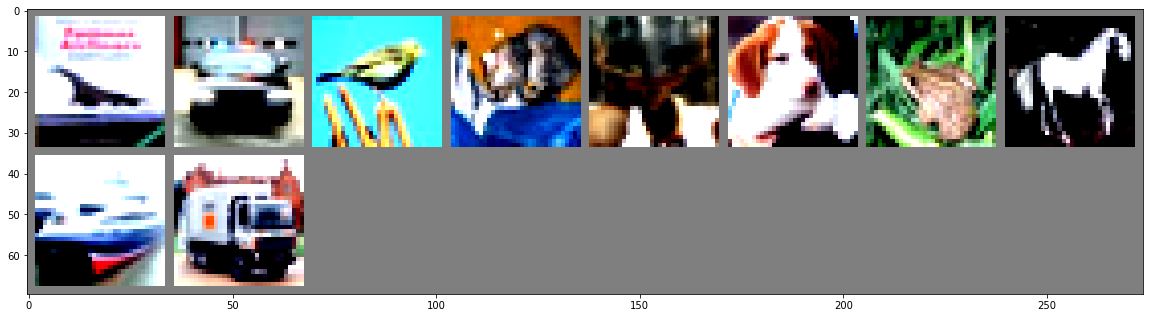

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


samples = []
samples_labels = []
samples_pred = []
selected = [3,66,67,0,26,16,4,13,1,11]

for i in selected:
  samples.append(org_images[i])
  samples_labels.append(org_labels[i])
  samples_pred.append(outputs[i])
samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)
imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
_, pred = torch.max(samples_pred.data, 1)

if not torch.all(torch.eq(pred,samples_labels)) :
  print("CAUTION: Your model was not sufficiently trained and contain an error. Retrain it!")

In [ ]:
print("sample labels",samples_labels)
print("sample preds",pred)

sample labels tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
sample preds tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


We see that the labels and predictions are the same

###FGSM

$x_{adv}=x_{benign}+\epsilon * sign(\nabla_{x_{benign}}l(\theta, x, y))$

In [ ]:
def FGSM(net, x, y, eps):
        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert


Creating adversary examples for samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



from left to right: perturbation, original image, adversary example

true label: 0 adversary label: 1


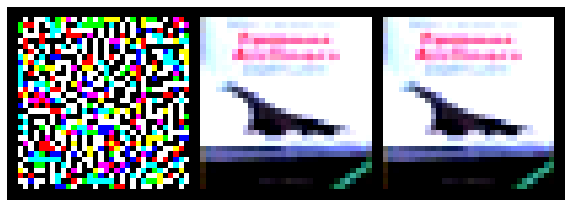

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 1 adversary label: 8


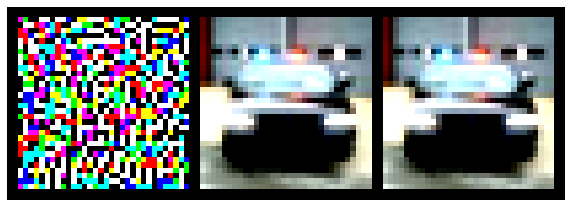

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 2 adversary label: 0


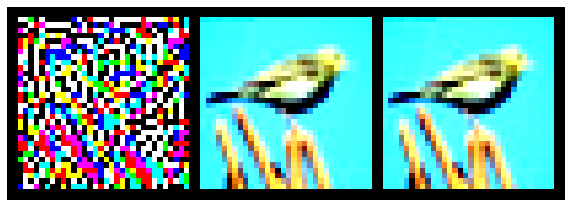

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 3 adversary label: 5


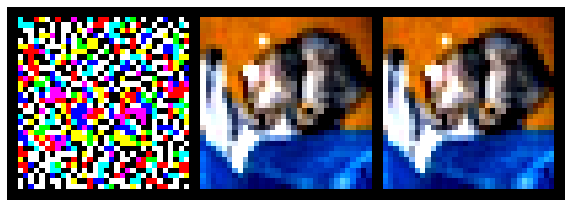

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 4 adversary label: 2


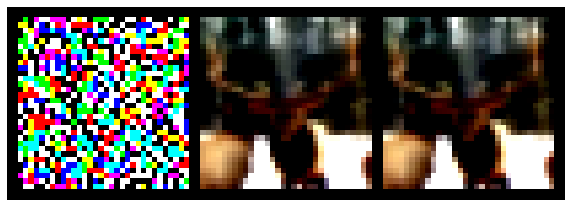

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 5 adversary label: 7


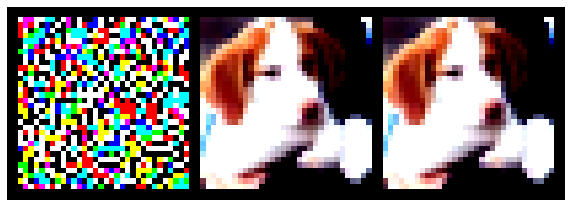

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 6 adversary label: 2


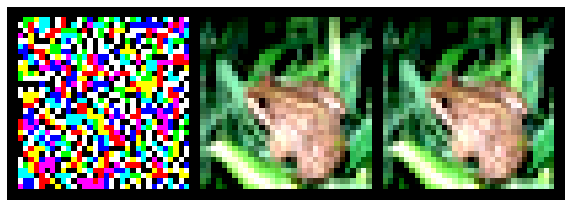

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 7 adversary label: 4


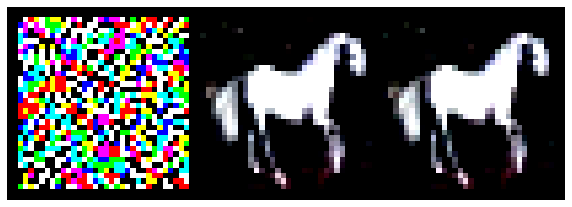

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 8 adversary label: 0


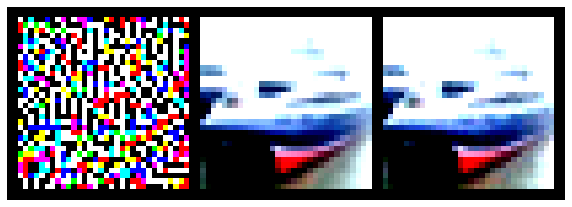

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: 9 adversary label: 1


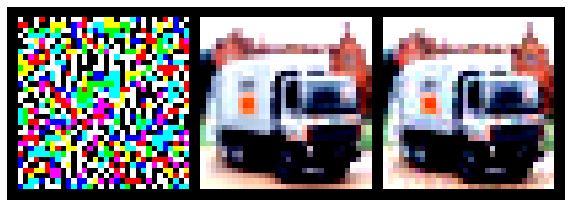

In [ ]:
print()
print('from left to right: perturbation, original image, adversary example')
print()
for i in selected:
    eps=1/255
    while True:
        x_adv, h_adv, y_adv, pert=FGSM(net, org_images[i].unsqueeze_(0),org_labels[i].unsqueeze_(0),eps)
        if y_adv.item()==org_labels[i].item():
            eps=eps+(1/255)
        else:
            break
    print("true label:", org_labels[i].item(), "adversary label:", y_adv.item())
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

    

### Adversarial Training with FGSM (net_adv model)

In [ ]:
print('==> Building new model..')
net_adv = ResNet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)


==> Building new model..


In [ ]:
def train_adv(epoch, net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

def test_adv(epoch, net):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [ ]:
train_losses_adv=[]
test_losses_adv=[]
epochs=40

for epoch in range(0,epochs):
    train_losses_adv.append(train_adv(epoch, net_adv))
    test_losses_adv.append(test_adv(epoch, net_adv))
    scheduler_adv.step()

print('Accuracy of the network on the test images: %d %%' % (acc))

####Training and Test loss of the Adverarially-trained model with FGSM

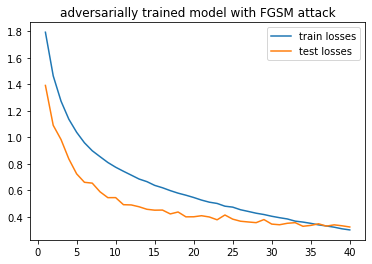

In [ ]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test losses')
plt.xlabel='epochs'
plt.ylabel='losses'
plt.title('adversarially trained model with FGSM attack')
plt.legend()
plt.show()

#### Comparing naturally trained model and adversarially trained model

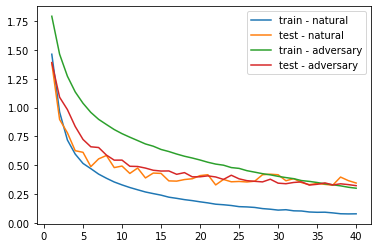

In [ ]:
plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
plt.xlabel='epochs'
plt.ylabel='losses'
plt.legend()
plt.show()


Training losses of the adversarially-trained model is higher than training losses of the naturally-trained model, which is intuitive, since the adversarially-trained model is trained against adversary examples, which makes it harder for the model to label these perturbed inputs correctly and results in higher error.

The loss of the naturally-trained model on test data is higher than the training loss, since test data is unseen by the model, resulting on higher error in classification.

However, the loss of the adversarially-trained model on test data is lower than the correspoding training loss. This is probably due to the fact that the test data are not adversary examples (in contrast to training data) and that the model has learned to extract important and useful features.

####Evaluating the Adversarially trained model on adversary examples




In [ ]:
def test_adv_exmpl(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)
            
        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
for eps in [4/355, 8/255, 12/255]:
    accuracy=test_adv_exmpl(net, net_adv, eps)
    print("epsilon:", eps, "accuracy:", accuracy)

epsilon: 0.011267605633802818 accuracy: 88.77
epsilon: 0.03137254901960784 accuracy: 88.1
epsilon: 0.047058823529411764 accuracy: 87.52


We see that as epsilon increases, the accuracy decreases, since for bigger epsilons, greater perturbations are allowed, therefore it becomes harder for the model to correctly label those perturbed examples.

#### Evaluating naturally-trained and adversariallyt-rained models on perturbed examples by gaussian noise




In [ ]:
def test_pert(net):
    accuracy=0
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            pert=torch.normal(8/255, 1/255, size=inputs.shape).to(device)

            x_adv=inputs+pert

            outputs = net(x_adv)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
acc_natural=test_pert(net)
acc_adversary=test_pert(net_adv)
print("accuracy of naturally trained model on perturbed data:", acc_natural)
print("accuracy of adversarially trained model on perturbed data:", acc_adversary)

accuracy of naturally trained model on perturbed data: 90.49
accuracy of adversarially trained model on perturbed data: 89.23


These two accuryacies are so close. However, the accuracy of the naturally trained model is slightly higher, which is weird! We expect the accuracy of the adversarially trained model on perturbed data to be higher than the accuary of naturally trained model, as the adversarially trained model is more robust and should have better performance on perturbed data.

Part 9 answer: The accuracy of the advesarially trained model is higher on perturbed data (89.23%) than on adversary examples produced by FGSM (88.1% for eps=8/255), which shows that FGSM produces stronger attacks so it is more difficult for the model to label perturbed inputs correctly under this attack compared to perturbed data by gaussian noise.

### FGSM on targeted examples

Part 10 answer: In targeted attacks, we want the model to misclassify its input to the given target class. Therefore, instead of just maximizing the loss of the true label, we maximize the loss of the true label and also minimize the loss for the alternative label.

In [ ]:
def FGSM_targeted(net,x,y,t,eps):
        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)-criterion(h_,t)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert  

In [ ]:
def test_adv_targ(net,model,eps,mode='largest_prob'):
    acc=0
    net.train()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode=='largest_prob':
            out=net(inputs)
            _,largest=torch.kthvalue(out,10,1)
            _,second_largest=torch.kthvalue(out,9,1)
            condition=largest-targets
            target_adv=torch.where(condition==0,second_largest, largest)
        else:
            out=net(inputs)
            _,smallest=torch.kthvalue(out,1,1)
            _,second_smallest=torch.kthvalue(out,2,1)
            condition=smallest-targets
            target_adv=torch.where(condition==0,second_smallest, smallest)

        x_adv, h_adv, y_adv, pert =FGSM_targeted(net,inputs,targets,target_adv,eps)

        with torch.no_grad():
                outputs = model(x_adv)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

####Class with the **Largest** probability (other than the true class) as the target class for FGSM-targeted attack

In [ ]:
eps=8/255
acc1=test_adv_targ(net,net,eps)
acc2=test_adv_targ(net,net_adv,eps)
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 28.35
accuracy of adversarially trained model against FGSM_targeted attack: 87.81


#### Class with the **Smallest** probability (other than the true class) as the target class for FGSM-targeted attack

In [ ]:
eps=8/255
acc1=test_adv_targ(net,net,eps, mode='smallest_prob')
acc2=test_adv_targ(net,net_adv,eps, mode='smallest_prob')
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 44.2
accuracy of adversarially trained model against FGSM_targeted attack: 87.96


Part 14 answer: We see that in both cases the accuracy of the
adversarially-trained model in much higher than the naturally-trained model since the adversarially-trained model has become more robust and therefore should have higher accuracy against adversary examples.

##Question 2

### PGD

$Repeat:\\
\delta:=\mathcal{P}(\delta+\alpha \nabla_{\delta} l(\theta, x, y)
$

[source](https://adversarial-ml-tutorial.org/adversarial_examples/)

In [ ]:
def PGD(net,x,y,alpha,epsilon,iter):
    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion=nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    pert=delta.detach()
    x_adv=x+pert
    h_adv=net(x_adv)
    _,y_adv=torch.max(h_adv.data,1)
    return x_adv, h_adv, y_adv, pert

In [ ]:
def test_PGD(net,model,alpha,eps,iter):
    acc=0
    net.train()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv,_,_,_=PGD(net,inputs,targets,alpha,eps,iter)

            with torch.no_grad():
                outputs = model(x_adv)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

#### Evaluating adversarially trained model (with FGSM) against PGD attack on test data

In [ ]:
alpha=3/255
eps=8/255
acc1_pgd=[]
for iter in [3,7,12]:
    acc=test_PGD(net,net_adv,alpha,eps,iter)
    acc1_pgd.append(acc)
    print("accuracy of net_adv against PGD attack with iters=",iter,": ",acc)

accuracy of net_adv against PGD attack with iters= 3 :  88.94
accuracy of net_adv against PGD attack with iters= 7 :  88.77
accuracy of net_adv against PGD attack with iters= 12 :  88.62


We see that as the iterations increase, the accuracy decreases. The reason is, as the number of iterations icreases, the PGD function produces stronger attacks which make it harder for the model to label them correctly. Therefore, the accuracy of the model decreases.

### Adversarial Training with PGD (net_pgd model)

In [ ]:
print('==> Building new model..')
net_pgd = ResNet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)


==> Building new model..


In [ ]:
def train_pgd(epoch, net, alpha, epsilon, iter):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv,_,_,_ = PGD(net,inputs,targets,alpha,epsilon,iter)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

def test_pgd(epoch, net):
    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [ ]:
train_losses_pgd=[]
test_losses_pgd=[]
epochs=40
alpha=3/255
epsilon=8/255
iter=3
for epoch in range(0,epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test_pgd(epoch, net_pgd))
    scheduler_pgd.step()

print('Accuracy of the network on the test images: %d %%' % (acc))

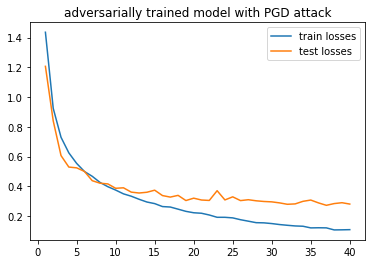

In [ ]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses_pgd, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test losses')
plt.xlabel='epochs'
plt.ylabel='losses'
plt.title('adversarially trained model with PGD attack')
plt.legend()
plt.show()

Comparing to plots of Question 1:

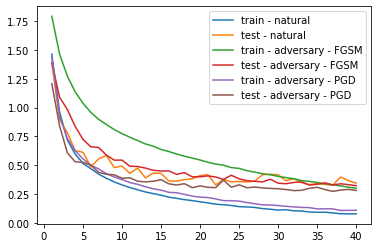

In [ ]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary - FGSM')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary - FGSM')
plt.plot(np.arange(1,epochs+1),train_losses_pgd, label='train - adversary - PGD')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test - adversary - PGD')
plt.xlabel='epochs'
plt.ylabel='losses'
plt.legend()
plt.show()

The plot above shows that the training losses of net_pgd (adversarially-trained with PGD) are much lower than net_adv (adversarially-trained with FGSM) and they are very close to the training losses of the naturally-trained model. Losses of net_pgd on test data is also lower than net_adv in most of the epochs. However, it is worth mentioning that the cost of training using PGD is higher than FGSM as PGD goes under several iterations to produce one adversary example.


In [ ]:
alpha=3/255
eps=8/255
acc2_pgd=[]

for iter in [3,7,12]:
    acc=test_PGD(net,net_pgd,alpha,eps,iter)
    acc2_pgd.append(acc)
    print("accuracy of net_pgd against PGD attack with iters=",iter,": ",acc)

accuracy of net_pgd against PGD attack with iters= 3 :  90.0
accuracy of net_pgd against PGD attack with iters= 7 :  88.47
accuracy of net_pgd against PGD attack with iters= 12 :  87.33


Just like before, We see here too that as the iterations increase, the accuracy decreases. The reason is, as the number of iterations icreases, the PGD function produces stronger attacks which makes it harder for the model to label them correctly. Therefore, the accuracy of the model decreases.

Comparing net_pgd and net_adv accuracies on PGD attack

In [ ]:
i=0
for iter in [3,7,12]:
    print('iter:', iter)
    print('accuracy of adversarially-trained model with FGSM against PGD:',acc1_pgd[i])
    print('accuracy of adversarially-trained model with PGD against PGD:',acc2_pgd[i])
    i=i+1


iter: 3
accuracy of adversarially-trained model with FGSM against PGD: 88.94
accuracy of adversarially-trained model with PGD against PGD: 90.0
iter: 7
accuracy of adversarially-trained model with FGSM against PGD: 88.77
accuracy of adversarially-trained model with PGD against PGD: 88.47
iter: 12
accuracy of adversarially-trained model with FGSM against PGD: 88.62
accuracy of adversarially-trained model with PGD against PGD: 87.33


net_adv is the model which was trained on adversary examples produced by FGSM attack, and net_pgd is the model which was trained on adversary examples produced by PGD attack.

The results show that net_pgd accuracies for different iterations have more variance than net_adv. Moreover, as net_pgd was trained on adversary examples produced using PGD attack with 3 iterations, it has a good performance (90%) on similar examples, i.e. for iter=3. However, its accuracy drops against PGD attack with higher iterations (7 and 12) and it is even lower than the accuracy of net_adv against these attacks. This is probably because net_pgd was trained with PGD-3 (iter=3) and it is more difficult for it to defend against PGD with 2 times or 4 times greater iterations.